# 01 - Data Cleaning & Pre-Processing

In [533]:
import pandas as pd
import matplotlib.pyplot as plt


In [534]:
# Source (via wine.com) : https://www.kaggle.com/datasets/salohiddindev/wine-dataset-scraping-from-wine-com  (prices in USD)
df_wine_com = pd.read_csv("./data/original_datasets/wine_com.csv", encoding='utf-16')

# Source (via Vivino.com): https://www.kaggle.com/datasets/budnyak/wine-rating-and-price (prices in EUR)
df_viv_1 = pd.read_csv('./data/original_datasets/vivino_one.csv')
df_viv_1.drop(columns=['Unnamed: 0'], inplace=True)

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_viv_2 = pd.read_csv('./data/original_datasets/vivino_two.csv')

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_val = pd.read_csv('./data/original_datasets/validation_set.csv')

In [535]:
# make columns snake_case 
df_viv_1.columns = [col.lower().replace(' ', '_') for col in df_viv_1.columns]
df_viv_2.columns = [col.lower().replace(' ', '_') for col in df_viv_2.columns]
df_wine_com.columns = [col.lower().replace(' %', '').replace(' ', '_') for col in df_wine_com.columns]
df_val.columns = [col.lower().replace(' ', '_') for col in df_val.columns]

# Cleaning wine.com Dataset

In [536]:
df_wine_com.head()

,names,color_wine,prices,ml,ratings,ratingsnum,countrys,abv,rates
0,00 Wines VGW Chardonnay 2017,White Wine,79.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS"
1,00 Wines VGR Pinot Noir 2019,Red Wine,99.99$,750,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP"
2,00 Wines EGW Chardonnay 2019,White Wine,115.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE"
3,100 Nails Ranch Pinot Noir 2019,Red Wine,16.99$,750,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW
4,100 Nails Ranch Chardonnay 2019,White Wine,16.99$,750,0.0,0,"Chardonnay from Sonoma County, California",14.2,0


In [537]:
df_wine_com.shape

(15254, 9)

In [538]:
df_wine_com.dtypes

names          object
color_wine     object
prices         object
ml              int64
ratings       float64
ratingsnum      int64
countrys       object
abv           float64
rates          object
dtype: object

In [539]:
# correct prices 
df_wine_com['prices'] = df_wine_com['prices'].str.replace(',', '').str.replace('$', '').astype(float)


In [540]:
# extract column for vintage from name
def get_vintage(x):
    try: 
        if int(x[-4:]) in range(1800, 2025):
            return str(x[-4:])
    except ValueError:
        return 'unknown'

df_wine_com['vintage'] = df_wine_com['names'].apply(get_vintage)
print(df_wine_com['vintage'].value_counts())

vintage
2019       3050
2020       2873
2018       2317
2021       1788
2017       1373
unknown    1089
2016        781
2015        437
2014        260
2013        163
2012        153
2010        116
2009         98
2011         85
2005         72
2008         68
2007         52
2002         50
2006         50
2001         44
2004         41
2000         41
2003         36
1999         34
1995         31
1996         27
1998         27
1997         18
2022         14
1994         14
1993          8
1989          6
1990          6
1991          4
1985          4
1983          3
1988          3
1928          2
1976          1
1968          1
1912          1
1973          1
1937          1
1977          1
1972          1
1969          1
1927          1
1954          1
1971          1
1978          1
1827          1
1975          1
1984          1
Name: count, dtype: int64


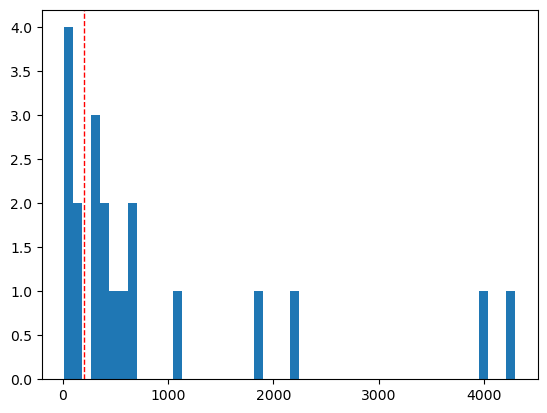

In [541]:
# investigate very old wines
old_wines = df_wine_com[df_wine_com['vintage'] < '1985']
plt.hist(old_wines['prices'], bins=50)
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=1, label='$200');

In [542]:
'''
remove vintage for wines below $200 in price and 'older' than 1985
having investgated them individually these are wines with the established year in their name 
as opposed to the actual vintage ( year grape was picked)
'''
df_wine_com.loc[(df_wine_com['prices'] < 200) & (df_wine_com['vintage'] < '1985'), 'vintage'] = 'unknown'

In [543]:
df_wine_com['color_wine'].value_counts()

color_wine
Red Wine                 9608
White Wine               3767
Sparkling & Champagne    1033
Pink and Rosé             429
0                         293
Collectible                60
Screw Cap                  29
Boutique                   19
Green Wine                 14
Great Gift                  2
Name: count, dtype: int64

In [544]:
def get_wine_variety(x):
    try: 
        if 'red' in x.lower(): 
            return 'red'
        elif 'white' in x.lower(): 
            return 'white'
        elif 'ros' in x.lower() or 'pink' in x.lower():
            return 'rose'
        elif 'sparkling'  in x.lower() or 'champagne' in x.lower() or 'prosecco' in x.lower() or 'espumante' in x.lower():
            return 'sparkling'
        else:
            return 'unknown'
    except:
        return 'error parsing' 

df_wine_com['wine_variety'] = df_wine_com['color_wine'].apply(get_wine_variety)


In [545]:
# check changes
df_wine_com.drop(columns=['color_wine'], inplace=True)
df_wine_com['wine_variety'].value_counts()

wine_variety
red          9608
white        3767
sparkling    1033
rose          429
unknown       417
Name: count, dtype: int64

In [546]:
# drop wines with ml not equal to 750 and then drop ml column
df_wine_com = df_wine_com[df_wine_com['ml'] == 750].copy()
df_wine_com.drop(columns=['ml'], inplace=True)

In [547]:
# rename columns 
df_wine_com.rename(columns = {'names' : 'name',
                            'prices' : 'price',
                            'ratings' : 'rating',
                            'ratingsnum': 'rating_qty', 
                            'rates' : 'reviewed_by'}, inplace = True)

In [548]:
# extract region name from country column 
def get_region(country):
    from_index = country.lower().find('from')
    comma_index = country.find(',')
    if from_index!= -1 and comma_index!= -1:
        return country[from_index+5:comma_index]
    elif from_index!= -1:
        return country[from_index+5:]
    else:
        return 'unknown'

df_wine_com['region'] = df_wine_com['countrys'].apply(get_region)

# drop 33 wines were region was not found 
df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()


In [549]:
# extract country name from country column 
def get_country(country):
    comma_index = country.find(',')
    if comma_index == -1:
        return 'unknown'
    else:
        return country.split(", ")[-1]
        

df_wine_com['country'] = df_wine_com['countrys'].apply(get_country)
df_wine_com['country'].value_counts()

# drop 33 wines were region was not found 
#df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()


country
France          4128
California      2845
Italy           2381
unknown         1363
Spain            926
Australia        433
Argentina        407
Washington       300
Germany          258
Oregon           241
Chile            219
Portugal         219
New Zealand      202
Other U.S.       107
South Africa      99
Austria           74
Greece            62
Canada             2
Name: count, dtype: int64

In [550]:
# investigate the unknowns
df_wine_com[df_wine_com['country'] == 'unknown']

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country
6,1000 Stories Bourbon Barrel Aged Prospectors' ...,19.99,0.0,0,Cabernet Sauvignon from California,0.0,WW,2020,red,California,unknown
7,1000 Stories American Barrel Aged Pinot Noir 2020,17.99,0.0,0,Pinot Noir from California,14.5,0,2020,red,California,unknown
8,1000 Stories Bourbon Barrel Aged Zinfandel 2020,18.99,3.8,11,Zinfandel from California,15.5,WW,2020,red,California,unknown
9,1000 Stories Bourbon Barrel Aged Chardonnay 2019,19.99,4.4,10,Chardonnay from California,14.4,TP,2019,white,California,unknown
10,1000 Stories Bourbon Barrel Aged Prospectors' ...,18.99,0.0,0,Cabernet Sauvignon from California,14.9,0,2018,red,California,unknown
...,...,...,...,...,...,...,...,...,...,...,...
15210,Vinos Atlantico Vera Vinho Verde Rose 2021,12.99,0.0,0,Rosé from Portugal,11.5,0,2021,rose,Portugal,unknown
15212,Vinos de Arganza Marques De Montejos Mencia 2020,13.99,0.0,0,Mencia from Spain,13.0,"JS, WW",2020,red,Spain,unknown
15214,Vinos de Arganza Alvarez de Toledo Godello 2021,11.99,4.8,29,Godello from Spain,0.0,WW,2021,white,Spain,unknown
15215,Vinos de Arganza Palacio de Arganza Cabernet S...,13.99,4.8,30,Other Red Blends from Spain,13.0,"JS, WW",2020,red,Spain,unknown


In [551]:
us_states = (
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
)

df_wine_com.loc[df_wine_com['region'].isin(us_states), 'country'] = 'United States'

In [552]:
# all unknown countries are cases where no region was available 
region_problems = df_wine_com[df_wine_com['country'] == 'unknown']
region_problems['region'].value_counts()

region
Israel               115
South Africa         105
Chile                 70
Portugal              70
Spain                 69
France                60
Italy                 55
Argentina             32
Uruguay               23
Austria               23
Greece                23
Australia             20
Lebanon               11
England               10
Slovenia               9
Germany                9
Hungary                8
Croatia                6
Brazil                 5
New Zealand            3
Armenia                3
China                  2
Other                  2
Macedonia (FYROM)      2
Other U.S.             1
Name: count, dtype: int64

In [553]:
# move those regions that are countries to the country column 
df_wine_com.loc[df_wine_com['country'] == 'unknown', 'country'] = df_wine_com.loc[df_wine_com['country'] == 'unknown', 'region']
# make those regions that are countries 'unknown'
df_wine_com.loc[df_wine_com['region'] == df_wine_com['country'], 'region'] = 'unknown'
# combine U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'Other U.S.', 'country'] = 'United States'
# combine all U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'California', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Washington', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Oregon', 'country'] = 'United States'
# rename macedonia 
df_wine_com.loc[df_wine_com['country'] == 'Macedonia (FYROM)', 'country'] = 'Macedonia'

df_wine_com['country'].value_counts()

country
France           4188
United States    4121
Italy            2436
Spain             995
Australia         453
Argentina         439
Portugal          289
Chile             289
Germany           267
New Zealand       205
South Africa      204
Israel            115
Austria            97
Greece             85
Uruguay            23
Lebanon            11
England            10
Slovenia            9
Hungary             8
Croatia             6
Brazil              5
Armenia             3
China               2
Other               2
Canada              2
Macedonia           2
Name: count, dtype: int64

In [554]:
df_wine_com.head()

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country
0,00 Wines VGW Chardonnay 2017,79.99,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS",2017,white,Willamette Valley,United States
1,00 Wines VGR Pinot Noir 2019,99.99,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP",2019,red,Willamette Valley,United States
2,00 Wines EGW Chardonnay 2019,115.99,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE",2019,white,Willamette Valley,United States
3,100 Nails Ranch Pinot Noir 2019,16.99,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW,2019,red,Central Coast,United States
4,100 Nails Ranch Chardonnay 2019,16.99,0.0,0,"Chardonnay from Sonoma County, California",14.2,0,2019,white,Sonoma County,United States


In [555]:
# attempt two methods of grape_variety extraction and compare them to validate manipulation
# method one from name 
def get_grape_1(x):
    from_index = x.lower().find(' from')
    return x[:from_index]
df_wine_com['grape_variety'] = df_wine_com['countrys'].apply(get_grape_1)

In [556]:
grapes = df_wine_com['grape_variety'].value_counts()
# save list of grapes for use later and comparision between other datasets
grape_list_1 = list(grapes.index)
grape_list_1

['Pinot Noir',
 'Cabernet Sauvignon',
 'Chardonnay',
 'Bordeaux Red Blends',
 'Other Red Blends',
 'Syrah/Shiraz',
 'Rhone Red Blends',
 'Non-Vintage Sparkling Wine',
 'Sangiovese',
 'Sauvignon Blanc',
 'Rosé',
 'Riesling',
 'Nebbiolo',
 'Tempranillo',
 'Other White Blends',
 'Sparkling Rosé',
 'Malbec',
 'Merlot',
 'Vintage Sparkling Wine',
 'Pinot Gris/Grigio',
 'Gamay',
 'Zinfandel',
 'Grenache',
 'Cabernet Franc',
 'Chenin Blanc',
 'Port',
 'Other White Wine',
 'Rhone White Blends',
 'Tuscan Blends',
 'Other Red Wine',
 'Barbera',
 'Bordeaux White Blends',
 'Albarino',
 'Muscat',
 'Gruner Veltliner',
 'Dolcetto',
 'Petite Sirah',
 'Vermentino',
 'Mencia',
 'Montepulciano',
 'Pinot Blanc',
 'Mourvedre',
 'Gewurztraminer',
 'Sherry',
 'Aglianico',
 'Vermouth',
 "Nero d'Avola",
 'Carmenere',
 'Viognier',
 'Nerello Mascalese',
 'Red Sparkling Wine',
 'Godello',
 'Madeira',
 'Carignan',
 'Verdejo',
 'Melon de Bourgogne',
 'Other Dessert',
 'Primitivo',
 'Verdicchio',
 'Garganega',
 'Cor

In [557]:
df_wine_com.head()

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety
0,00 Wines VGW Chardonnay 2017,79.99,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS",2017,white,Willamette Valley,United States,Chardonnay
1,00 Wines VGR Pinot Noir 2019,99.99,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP",2019,red,Willamette Valley,United States,Pinot Noir
2,00 Wines EGW Chardonnay 2019,115.99,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE",2019,white,Willamette Valley,United States,Chardonnay
3,100 Nails Ranch Pinot Noir 2019,16.99,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW,2019,red,Central Coast,United States,Pinot Noir
4,100 Nails Ranch Chardonnay 2019,16.99,0.0,0,"Chardonnay from Sonoma County, California",14.2,0,2019,white,Sonoma County,United States,Chardonnay


In [558]:
# test a function to try and extract producer name from 'name' column
df_wine_com['name'][0].split(f"{df_wine_com['grape_variety'][0]}")[0].strip()

'00 Wines VGW'

In [590]:
#def extract_producer(row):
#    if row['name'].find(f"{row['grape_variety']}")!= -1:
#        output = row['name'].split(f"{row['grape_variety']}")[0].strip()
#    else: 

    
#    return output

def get_producer(x):
    prepositions = ['of', 'de', 'la', 'di', 'qua', 'du', 'non', 'do', 'des', 'a', 'the', 'et']
    x_words = x.split(' ')
    if x_words[1].lower() in prepositions:
        if x_words[2].lower() in prepositions:
            if x_words[3].lower() in prepositions:
                producer = x_words[0] + ' ' + x_words[1] + ' ' + x_words[2] + ' ' + x_words[3] + ' ' + x_words[4]
                for item in grape_list_1:
                    if item in producer:
                        return producer.split(f'{item}')[0].strip()
                    else:
                        return producer
            producer = x_words[0] + ' ' + x_words[1] + ' ' + x_words[2] + ' ' + x_words[3]
            for item in grape_list_1:
                if item in producer:
                    return producer.split(f'{item}')[0].strip()
                else:
                    return producer
        producer = x_words[0] +' ' + x_words[1] +' ' + x_words[2]
        for item in grape_list_1:
            if item in producer:
                return producer.split(f'{item}')[0].strip()
            else:
                return producer
    producer = x_words[0] + ' ' + x_words[1]
    for item in grape_list_1:
        if item in producer:
            return producer.split(f'{item}')[0].strip()
        else:
            return producer   

df_wine_com['producer'] = df_wine_com['name'].apply(get_producer)

In [591]:
for i in df_wine_com['producer'].value_counts().index:
    print(i)

Louis Latour
Chanson Pere
Albert Bichot
Louis Jadot
M. Chapoutier
Chateau Ste.
Domaine Robert
Albert Boxler
Joseph Drouhin
Domaine Jean
Dr. Loosen
Francis Ford
Bouchard Pere
Chateau Leoville
Billaud-Simon Chablis
Domaine de la Janasse
Domaine Bruno
Chateau Mouton
Gerard Bertrand
J. Lohr
Rodney Strong
Domaine Perrot-Minot
Sheridan Vineyard
Domaine Bousquet
Stag's Leap
Domaine de la Romanee-Conti
Realm Cellars
Chateau de Saint
Jean-Louis Chave
Chateau Cos
Chateau Pavie
K Vintners
Chateau Ducru-Beaucaillou
Pride Mountain
Menage a Trois
Domaine de Montille
Selbach Oster
Baron Herzog
Guigal Cote
Maximin Grunhaus
Chateau Rayas
J.J. Prum
Marchesi di Barolo
G.D. Vajra
Paolo Scavino
Clos du Caillou
Pio Cesare
Chateau Canon
Fisher Vineyards
Michel Magnien
Chateau de la Maltroye
Stolpman Vineyards
Pascual Toso
Chateau Maris
L'Ecole 41
Elvio Cogno
Rhys Vineyards
Cono Sur
Vincent Girardin
Domaine Ponsot
Robert Mondavi
Lucien Le
Sadie Family
Familia Torres
Kapcsandy Family
Vineyard 29
Joseph Colin
B

In [444]:
df_wine_com['rating_qty'].value_counts()

rating_qty
0      10346
5        309
6        291
7        249
8        189
       ...  
290        1
176        1
131        1
539        1
186        1
Name: count, Length: 271, dtype: int64

In [360]:
# investgate wine of price 9999.99 - this is a collectable highly prized wine producer Chateau Petrus
df_wine_com[df_wine_com['price'] == 9999.99]

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer
3810,Chateau Petrus 2016,9999.99,4.7,11,"Bordeaux Red Blends from Pomerol, Bordeaux, Fr...",14.5,"JS, RP, D, JD, WE, WS",2016,red,Pomerol,France,Bordeaux Red Blends,Chateau Petrus


In [361]:
# convert price to GBP £ using https://www.xe.com/currencytables/ at date of scrape
df_wine_com['price'] = df_wine_com['price'] * 0.8214659183132513

In [362]:
# create columns for each critic as per https://www.wine.com/content/landing/icons-explained#:~:text=Professional%20Ratings,range%20within%20the%20tasting%20note.
# WS Wine Spectator
#RP Robert Parker's The Wine Advocate
#W&S Wine & Spirits
#CG Connoisseurs' Guide
#WE Wine Enthusiast
#WW Wilfred Wong, Wine.com
#BH Allen Meadows' Burghound
#JS JamesSuckling.com
#TP Tasting Panel
#D Decanter
#V Vinous
#JD Jeb Dunnuck
#TA Tim Atkin
#WH Whisky Advocate
#JM Jasper Morris Inside Burgundy
#SJ The Somm Journal

In [363]:
df_wine_com.drop(columns=['countrys'], inplace=True)

# Cleaning Vivino 1 Dataset

In [364]:
df_viv_1.head()

,name,country,region,winery,rating,numberofratings,price,year,category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,red
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,red
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,red
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,red
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,red


In [365]:
df_viv_1.shape

(34664, 9)

In [366]:
df_viv_1.rename(columns = {'winery' : 'producer', 
                           'numberofratings' : 'rating_qty', 
                           'category' : 'wine_variety',
                           'year' : 'vintage'
                           }, inplace = True)

In [367]:
df_viv_1.dtypes

name             object
country          object
region           object
producer         object
rating          float64
rating_qty        int64
price           float64
vintage          object
wine_variety     object
dtype: object

In [368]:
# make name formatting structure the same as wine_com datafram
df_viv_1['name'] = df_viv_1['producer'] + ' ' + df_viv_1['name']

In [369]:
df_viv_1['region'].value_counts()

region
Rioja                                  1300
Toscana                                 996
Stellenbosch                            928
Saint-Émilion Grand Cru                 828
Barolo                                  700
                                       ... 
Sachsen                                   4
Coteaux Varois en Provence                4
Orvietano Rosso                           4
Mercurey 1er Cru 'Le Clos L'Evêque'       4
Mount Veeder                              4
Name: count, Length: 624, dtype: int64

In [370]:
df_viv_1['country'].value_counts()

country
Italy            10600
France            9024
Spain             4568
South Africa      2000
United States     1496
Chile             1304
Germany            992
Australia          984
Argentina          984
Portugal           920
Austria            880
New Zealand        252
Brazil             160
Romania             92
Lebanon             60
Israel              52
Greece              52
Switzerland         48
Hungary             36
Moldova             32
Slovenia            32
Turkey              24
Georgia             20
Uruguay             16
Croatia              8
Bulgaria             8
Canada               8
Mexico               4
China                4
Slovakia             4
Name: count, dtype: int64

In [371]:
df_viv_1['vintage'].value_counts()

vintage
2016    7104
2017    6232
2015    5584
2018    4396
2014    3192
2013    2256
2012    1484
2011    1112
2010     696
2005     616
2019     464
2009     336
2008     320
2006     176
2007     172
2004     108
2000      76
1999      60
2001      48
2003      44
N.V.      32
1997      28
2002      28
1998      24
1996      20
1995      16
1992      12
1990       8
1989       8
1993       4
1988       4
1991       4
Name: count, dtype: int64

In [372]:
df_viv_1.loc[df_viv_1['vintage'] == 'N.V.', 'vintage'] = 'unknown'

In [373]:
df_viv_1['rating'].describe()

count    34664.000000
mean         3.890342
std          0.308534
min          2.500000
25%          3.700000
50%          3.900000
75%          4.100000
max          4.800000
Name: rating, dtype: float64

In [374]:
df_viv_1['rating_qty'].describe()

count    34664.000000
mean       415.287445
std        899.687438
min         25.000000
25%         66.000000
50%        157.000000
75%        401.000000
max      20293.000000
Name: rating_qty, dtype: float64

In [375]:
# investgate wines with high number of ratings
high_rating_qty = df_viv_1[df_viv_1['rating_qty'] > 10000]
high_rating_qty

,name,country,region,producer,rating,rating_qty,price,vintage,wine_variety
240,Catena Malbec 2017,Argentina,Mendoza,Catena,4.1,10676,13.50,2017,red
282,Opus One Overture N.V.,United States,Napa Valley,Opus One,4.4,10799,154.99,unknown,red
412,Marqués de Riscal Rioja Reserva 2015,Spain,Rioja,Marqués de Riscal,4.1,11170,15.50,2015,red
492,Zenato Ripassa Valpolicella Ripasso Superiore ...,Italy,Valpolicella Ripasso,Zenato,4.2,11433,19.99,2015,red
622,Alamos Malbec 2018,Argentina,Mendoza,Alamos,3.7,11920,8.40,2018,red
652,Ramón Bilbao Crianza Rioja 2016,Spain,Rioja,Ramón Bilbao,3.9,12079,8.60,2016,red
843,Ramón Bilbao Crianza Rioja 2015,Spain,Rioja,Ramón Bilbao,3.8,12778,8.95,2015,red
943,Caballo Loco Red Blend N.V.,Chile,Lontue Valley,Caballo Loco,4.4,13136,34.07,unknown,red
1161,San Marzano 60 Sessantanni Old Vines Primitivo...,Italy,Primitivo di Manduria,San Marzano,4.5,14148,30.95,2015,red
1623,San Marzano Cinquanta Collezione 2012,Italy,Vino d'Italia,San Marzano,4.3,16262,17.57,2012,red


In [376]:
df_viv_1['price'].describe()

count    34664.000000
mean        39.145065
std         84.932632
min          3.550000
25%         10.680000
50%         18.200000
75%         38.160000
max       3410.790000
Name: price, dtype: float64

In [377]:
# convert price to GBP £ from € using https://www.xe.com/currencytables/ at date of scrape
df_viv_1['price'] = df_viv_1['price'] * 0.8371915735092197

In [378]:
# make empty abv column 
df_viv_1['abv'] = 0

In [379]:
df_viv_1['reviewed_by'] = 'unknown'

# Cleaning Vivino 2 Dataset

In [380]:
df_viv_2.head()

,winery,year,wine_id,wine,rating,num_review,price,country,region
0,Viña Oria,2019,1812139,Garnacha 2019,3.5,327,2.50,España,Cariñena
1,Ayuso,2017,2084964,Abadia del Roble Tinto 2017,2.9,52,2.54,España,La Mancha
2,Castillo de Liria,2020,1643745,Bobal - Shiraz 2020,3.4,85,2.56,España,Valencia
3,Castillo de Liria,2019,1643745,Bobal - Shiraz 2019,3.6,305,2.56,España,Valencia
4,Finca Venta de Don Quijote,2020,7166356,Tempranillo - Syrah 2020,3.6,129,2.72,España,Castilla


In [334]:
df_viv_2.rename(columns = {'winery' : 'producer', 
                           'num_review' : 'rating_qty', 
                           'year' : 'vintage',
                           'wine' : 'name'
                           }, inplace = True)

# Cleaning Validation Dataset

In [272]:
df_val.head()

,title,description,price,capacity,grape,secondary_grape_varieties,closure,country,unit,characteristics,per_bottle_/_case_/_each,type,abv,region,style,vintage,appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley
